### CNN for Assamese characters

The data for the Assamese characters have been taken from this [UCI respository](https://archive.ics.uci.edu/ml/datasets/Online+Handwritten+Assamese+Characters+Dataset#). There are about 8326 images corresponding to various letters, combined letters (*zuktakkhor*) and numbers. The original data has not contain images but instead consist of lines and strokes used for writing each alphabet. This will not be useful for character recognition and thus I have converetd the data into images and categorised the data into train and test sets which will make it easier to use Keras for classification. As a first trial I will be using a Convolutional Neural Network to test the accuracy.

Assamese is the Eastern most of the Indo-European group of languages. Like Hindi there are letters can be combined to form compound alphabets. The dataset contains almost all such combinations and we thus have around 183 classes. This leads to only around 50 images per class which is less than it is desired. This is the only existing extensive set of handwritten Assamese characters.

We will be using Keras in this notebook as it is the easiest to implement and test a neural network. 

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import metrics
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

In [180]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Dropout(0.25))

# the model so far outputs 3D feature maps (height, width, features)

# dense layer
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(183, activation = 'softmax'))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In order to have nicer convergence it will be best to employ a learning rate that will decrease with epoch. At higher epoch the loss does not reduce significantly and we can explore the loss region more efficiently by reducing the learning rate. 

In [181]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [182]:
batch_size = 30

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.4,
        zoom_range=0.4,
        horizontal_flip=False)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(50, 50),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(50, 50),
        batch_size=batch_size,
        class_mode='categorical')

model.summary()

Found 6563 images belonging to 183 classes.
Found 1649 images belonging to 183 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 9, 9, 64)          18496     
______________________________________________________

In [183]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=150,
        validation_data=validation_generator,
        validation_steps=1000 // batch_size)
model.save_weights('first_try.h5')


Epoch 1/150
66/66 [==============================] - 4s 54ms/step - loss: 5.2250 - acc: 0.0057 - val_loss: 5.2147 - val_acc: 0.0020
Epoch 2/150
66/66 [==============================] - 3s 44ms/step - loss: 5.2161 - acc: 0.0066 - val_loss: 5.2114 - val_acc: 0.0030
Epoch 3/150
66/66 [==============================] - 3s 45ms/step - loss: 5.2123 - acc: 0.0051 - val_loss: 5.2004 - val_acc: 0.0111
Epoch 4/150
66/66 [==============================] - 3s 46ms/step - loss: 5.1120 - acc: 0.0237 - val_loss: 4.9569 - val_acc: 0.0526
Epoch 5/150
66/66 [==============================] - 3s 43ms/step - loss: 4.8339 - acc: 0.0480 - val_loss: 4.4444 - val_acc: 0.1143
Epoch 6/150
66/66 [==============================] - 3s 47ms/step - loss: 4.5252 - acc: 0.0697 - val_loss: 4.0845 - val_acc: 0.1293
Epoch 7/150
66/66 [==============================] - 3s 49ms/step - loss: 4.1992 - acc: 0.0955 - val_loss: 3.5330 - val_acc: 0.2073
Epoch 8/150
66/66 [==============================] - 3s 43ms/step - loss: 3.

66/66 [==============================] - 3s 43ms/step - loss: 0.8165 - acc: 0.7434 - val_loss: 0.4777 - val_acc: 0.8615
Epoch 63/150
66/66 [==============================] - 3s 41ms/step - loss: 0.8256 - acc: 0.7413 - val_loss: 0.5127 - val_acc: 0.8434
Epoch 64/150
66/66 [==============================] - 3s 47ms/step - loss: 0.7956 - acc: 0.7465 - val_loss: 0.5372 - val_acc: 0.8069
Epoch 65/150
66/66 [==============================] - 3s 41ms/step - loss: 0.7957 - acc: 0.7545 - val_loss: 0.5888 - val_acc: 0.8301
Epoch 66/150
66/66 [==============================] - 3s 43ms/step - loss: 0.8241 - acc: 0.7414 - val_loss: 0.5086 - val_acc: 0.8465
Epoch 67/150
66/66 [==============================] - 3s 44ms/step - loss: 0.8104 - acc: 0.7396 - val_loss: 0.5052 - val_acc: 0.8534
Epoch 68/150
66/66 [==============================] - 3s 43ms/step - loss: 0.7711 - acc: 0.7646 - val_loss: 0.5655 - val_acc: 0.8222
Epoch 69/150
66/66 [==============================] - 3s 44ms/step - loss: 0.7871 

66/66 [==============================] - 3s 42ms/step - loss: 0.5610 - acc: 0.8285 - val_loss: 0.3848 - val_acc: 0.8879
Epoch 124/150
66/66 [==============================] - 3s 43ms/step - loss: 0.5140 - acc: 0.8391 - val_loss: 0.3662 - val_acc: 0.8797
Epoch 125/150
66/66 [==============================] - 3s 42ms/step - loss: 0.5930 - acc: 0.8227 - val_loss: 0.3735 - val_acc: 0.8868
Epoch 126/150
66/66 [==============================] - 3s 42ms/step - loss: 0.5881 - acc: 0.8263 - val_loss: 0.4134 - val_acc: 0.8717
Epoch 127/150
66/66 [==============================] - 3s 44ms/step - loss: 0.5652 - acc: 0.8106 - val_loss: 0.3911 - val_acc: 0.8857
Epoch 128/150
66/66 [==============================] - 3s 42ms/step - loss: 0.5909 - acc: 0.8223 - val_loss: 0.4772 - val_acc: 0.8515
Epoch 129/150
66/66 [==============================] - 3s 44ms/step - loss: 0.5590 - acc: 0.8197 - val_loss: 0.4057 - val_acc: 0.8807
Epoch 130/150
66/66 [==============================] - 3s 43ms/step - loss: 

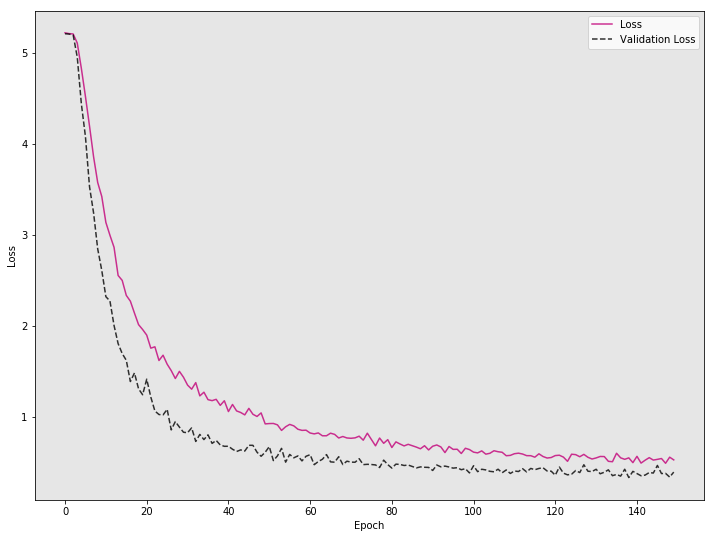

In [184]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
ax.plot(history.history['loss'], '-', color = 'xkcd:magenta', label = 'Loss', alpha = 0.8)
ax.plot(history. history['val_loss'], '--', color = 'xkcd:black', label = 'Validation Loss', alpha = 0.8)
ax.legend(loc = 'best')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_facecolor('0.9')

In [185]:
%matplotlib inline

In [186]:
predict_generator = test_datagen.flow_from_directory(
                'data/test',
                target_size=(50, 50),
                batch_size=1650,
                class_mode='categorical', shuffle = False)
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Predict the output
y_pred = model.predict_generator(predict_generator)
#y_pred_classes
y_pred_classes = np.argmax(y_pred, axis = 1)

#y true values

y_true = validation_generator.classes

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)

Found 1649 images belonging to 183 classes.


In [187]:
accuracy = cm.trace()/cm.sum()

In [188]:
print('The overall accuracy is: {}% '.format(accuracy*100))

The overall accuracy is: 88.84172225591267% 


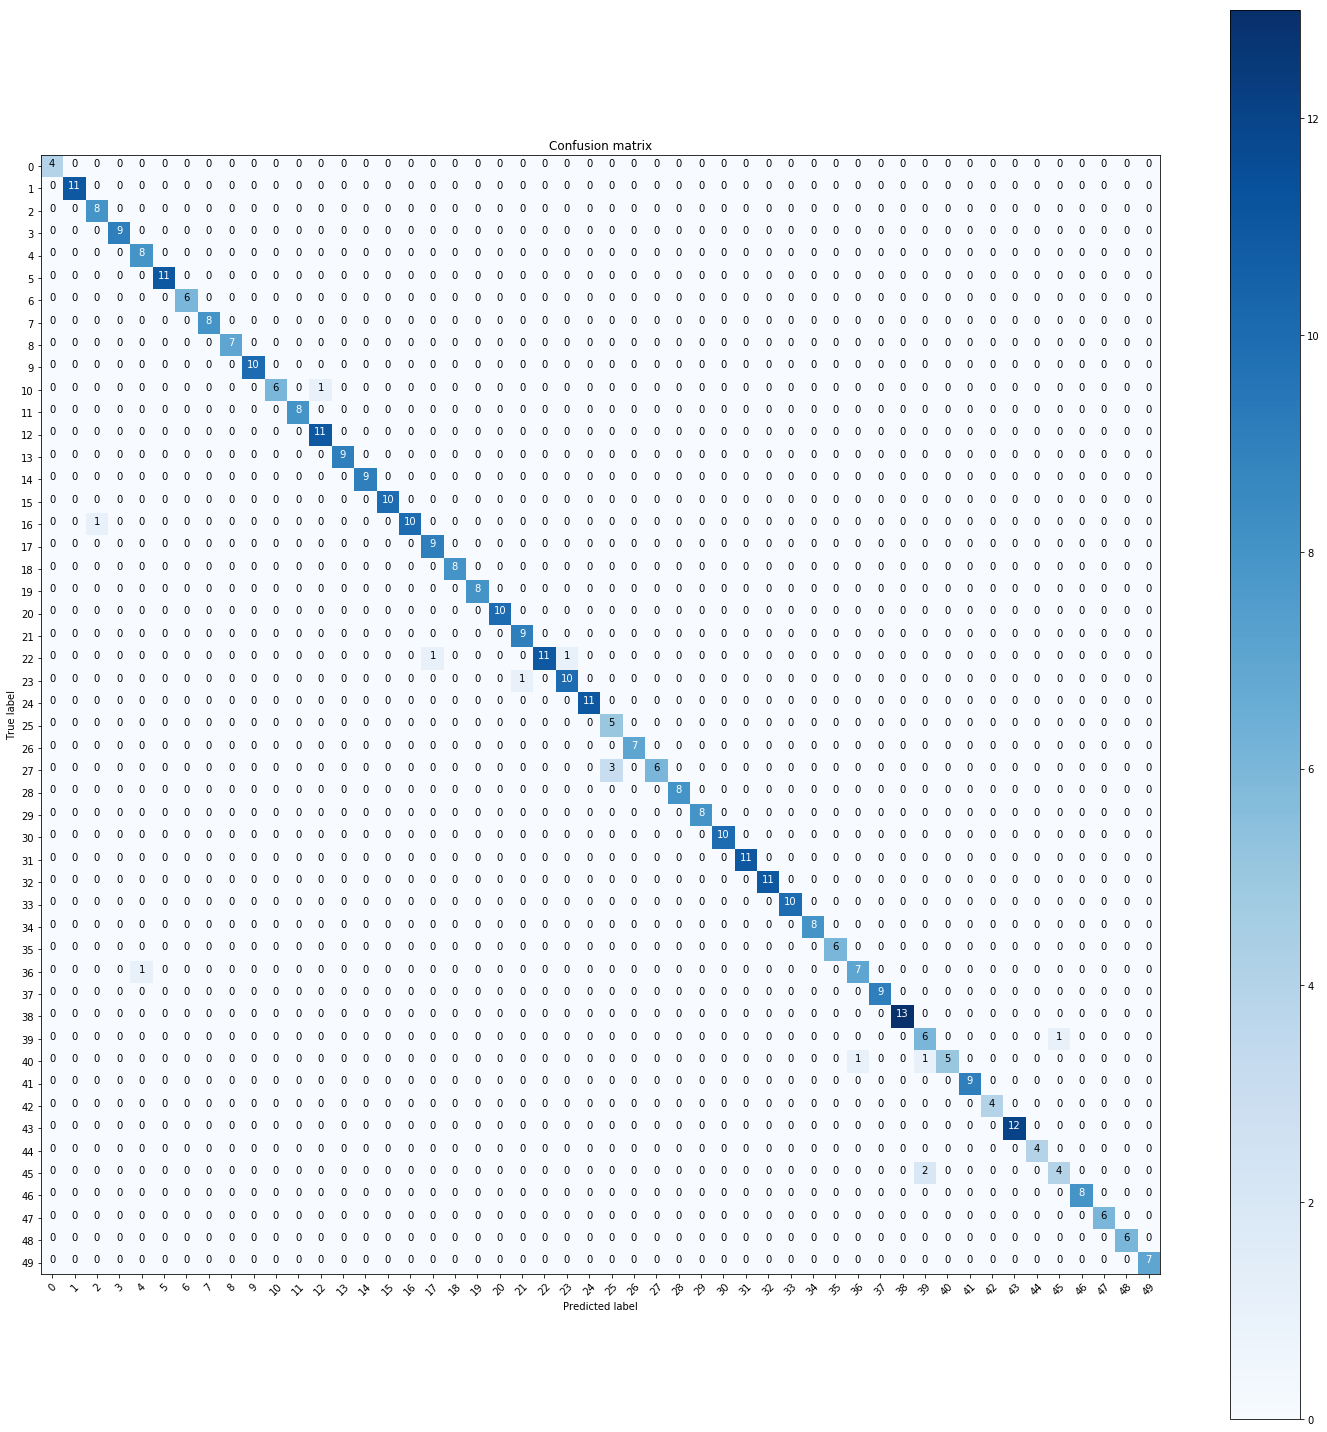

In [189]:
plt.figure(figsize = (20, 20))
plot_confusion_matrix(cm[:50,:50], classes = range(50)) 

I am plotting just the first 50 of the classes in order to demonstrate how the confusion matrix looks like.

In [190]:
x = train_generator.class_indices

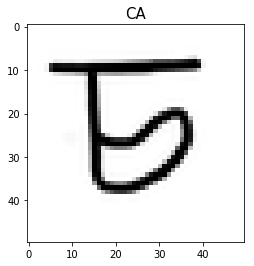

In [192]:

from resizeimage import resizeimage
def predict_new_image(path):
        test1 = load_img(path)
        test2 = resizeimage.resize_contain(test1, [50,50]).convert('RGB')
        test = img_to_array(test2)
        test = np.expand_dims(test, axis = 0)
        result = model.predict(test)
        x = train_generator.class_indices
        all_label = list(x.keys())
        plt.figure()
        plt.clf()
        plt.imshow(test2, cmap = 'Greys')
        plt.title(all_label[result.argmax()], fontsize = 15)
predict_new_image('predict/predict_16.jpg')